In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import ast


'all'

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import os

while "notebooks" in os.getcwd():
    os.chdir("..")

from time import time
from pathlib import Path
from tqdm import tqdm
import torch
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset
import math
from typing import List, Optional, Tuple, Union
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import warnings
from bert_score import BERTScorer
warnings.filterwarnings("ignore")
from copy import deepcopy
from openai import OpenAI

from src.utils import rotate_half, apply_rotary_pos_emb, repeat_kv, \
    get_context_length, insert_needle

from src.attention_saver import Mistral7BAttentionSaver
from src.influence.influence import Influence

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    cache_dir = "/Data"    
)

## Experiment 3 - Giving attention to the question  

In [4]:
base_path = "data/study-03-finding_needles/{model_name}/09/generated_text_delta={delta_attention}.parquet"
checkpoint_path = "data/study-03-finding_needles/{model_name}/09/checkpoints/generated_text_delta={delta_attention}.parquet"
model_name = "Mistral-7B-Instruct-v0.1"

needle = "\nThe best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.\n"
question = "What is the best thing to do in San Francisco?"

In [5]:
# tqdm.pandas()
# df = load_dataset("stas/openwebtext-10k", cache_dir="/Data")['train'].to_pandas()
# df["text_len"] = df["text"].apply(lambda x: len(x.split(" ")))
# df['context_length'] = df['text'].progress_apply(get_context_length, tokenizer = tokenizer)

# chunks = []
# for n in range (9):
#     samples = df.query(f"context_length > {500*n} & context_length < {500*(n+1)}")\
#         .sample(50, random_state = 42)
    
#     chunks.append(samples)

# study_df = pd.concat(chunks)\
#     .sort_values("context_length", ascending = False)


# all_df = []

# for depth_percent in tqdm(range(0, 110, 10)):

#     percent_df = study_df.apply(
#         insert_needle, 
#         depth_percent = depth_percent, 
#         question = question,
#         needle = needle, 
#         axis = 1
#     )

#     all_df.append(percent_df)

# needle_in_a_haystack_df = pd.concat(all_df)\
#     .reset_index(drop = True)

In [6]:
all_df = []
for delta_attention in [0., 0.25, 0.5, 1., ]:
    try:
        df = pd.read_parquet(
            base_path.format(model_name = model_name, delta_attention = delta_attention)
        )

    except:
        df = pd.read_parquet(
            checkpoint_path.format(model_name = model_name, delta_attention = delta_attention)
        )

    df['delta'] = delta_attention
    # df = pd.merge(
    #     df,
    #     needle_in_a_haystack_df[['text']],
    #     left_index= True,
    #     right_index=True
    # )

    all_df.append(df)

In [7]:
results_df = pd.concat(all_df)\
    .reset_index(drop = True)

In [8]:
results_df['context'] = results_df['generated_text']\
    .apply(lambda x: x[0].split("[/INST]")[0].split("[INST]")[1])
results_df['generated_text'] = results_df['generated_text']\
    .apply(lambda x: x[0].split("[/INST]")[1])

results_df.head()

,generated_text,target,question,instruction,context_length,depth,text_index,delta,context
0,The best thing to do in San Francisco is to s...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,4491,0.0,0,0.0,\n<question>\n Your objective is to answer th...
1,The best thing to do in San Francisco is to s...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,4476,0.0,1,0.0,\n<question>\n Your objective is to answer th...
2,The best thing to do in San Francisco is to s...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,4458,0.0,2,0.0,\n<question>\n Your objective is to answer th...
3,The best thing to do in San Francisco is to e...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,4439,0.0,3,0.0,\n<question>\n Your objective is to answer th...
4,The best thing to do in San Francisco is to g...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,4402,0.0,4,0.0,\n<question>\n Your objective is to answer th...


In [12]:
results_df

,generated_text,target,question,instruction,context_length,depth,text_index,delta,context,score,context_length_bins,depth_bins
0,The best thing to do in San Francisco is to s...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,4491,0.0,0,0.0,\n<question>\n Your objective is to answer th...,True,"(4000, 4500]","(-0.001, 10.0]"
1,The best thing to do in San Francisco is to s...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,4476,0.0,1,0.0,\n<question>\n Your objective is to answer th...,True,"(4000, 4500]","(-0.001, 10.0]"
2,The best thing to do in San Francisco is to s...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,4458,0.0,2,0.0,\n<question>\n Your objective is to answer th...,True,"(4000, 4500]","(-0.001, 10.0]"
3,The best thing to do in San Francisco is to e...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,4439,0.0,3,0.0,\n<question>\n Your objective is to answer th...,True,"(4000, 4500]","(-0.001, 10.0]"
4,The best thing to do in San Francisco is to g...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,4402,0.0,4,0.0,\n<question>\n Your objective is to answer th...,False,"(4000, 4500]","(-0.001, 10.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
19795,The best thing to do in San Francisco is not ...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,224,100.0,4945,1.0,\n<question>\n Your objective is to answer th...,False,"(0, 500]","(90.0, 100.0]"
19796,The provided context does not mention anythin...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,213,100.0,4946,1.0,\n<question>\n Your objective is to answer th...,False,"(0, 500]","(90.0, 100.0]"
19797,The best thing to do in San Francisco is eat ...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,213,100.0,4947,1.0,\n<question>\n Your objective is to answer th...,True,"(0, 500]","(90.0, 100.0]"
19798,The best thing to do in San Francisco is eat ...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,Your objective is to answer the following ques...,204,100.0,4948,1.0,\n<question>\n Your objective is to answer th...,True,"(0, 500]","(90.0, 100.0]"


In [9]:
results_df['score'] = results_df['generated_text'].apply(lambda x: ('dolores' in x.lower()))

In [10]:
results_df['context_length_bins'] = pd.cut(
    results_df['context_length'],
    range(0, 5000, 500)
)

# results_df['depth'] = results_df['depth'].fillna(results_df['depth_x'])

results_df['depth_bins'] = pd.cut(
    results_df['depth'],
    range(0,110,10),
    include_lowest = True
)

(0.0, 1.0)

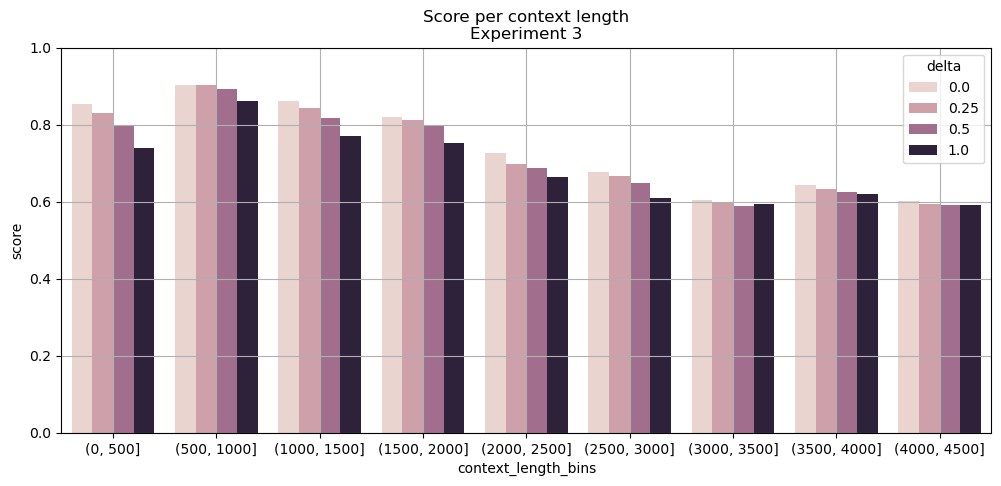

In [11]:
performance_df = results_df\
    .groupby(['delta', "context_length_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.figure(figsize=(12,5))

sns.barplot(
    performance_df,
    x = 'context_length_bins',
    y = "score",
    hue = "delta"
)

plt.title("Score per context length\nExperiment 3")
plt.grid()
plt.ylim([0,1])

(0.0, 1.0)

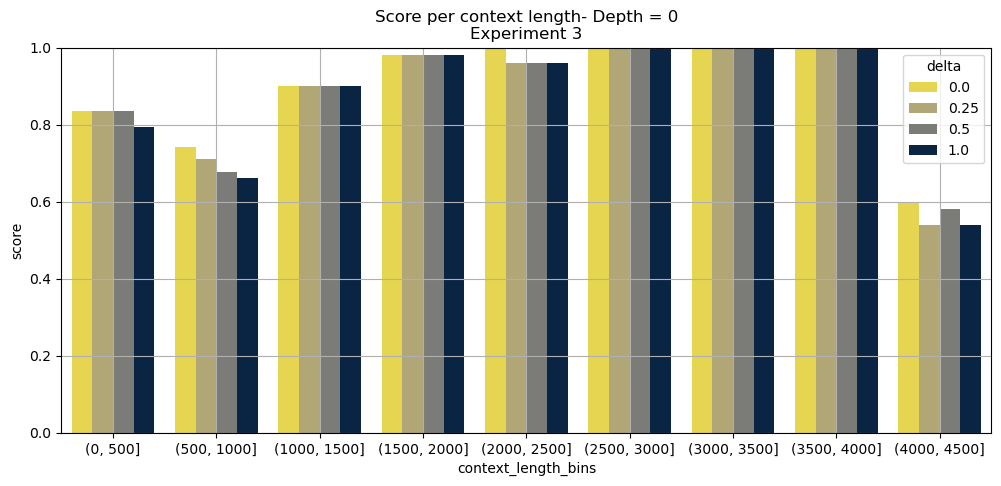

In [14]:
performance_df = results_df\
    .query("depth == 0")\
    .groupby(['delta', "context_length_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.figure(figsize=(12,5))

sns.barplot(
    performance_df,
    x = 'context_length_bins',
    y = "score",
    hue = "delta",
    palette = 'cividis_r'
)

plt.title("Score per context length- Depth = 0\nExperiment 3")
plt.grid()

plt.ylim([0,1])

(0.0, 1.0)

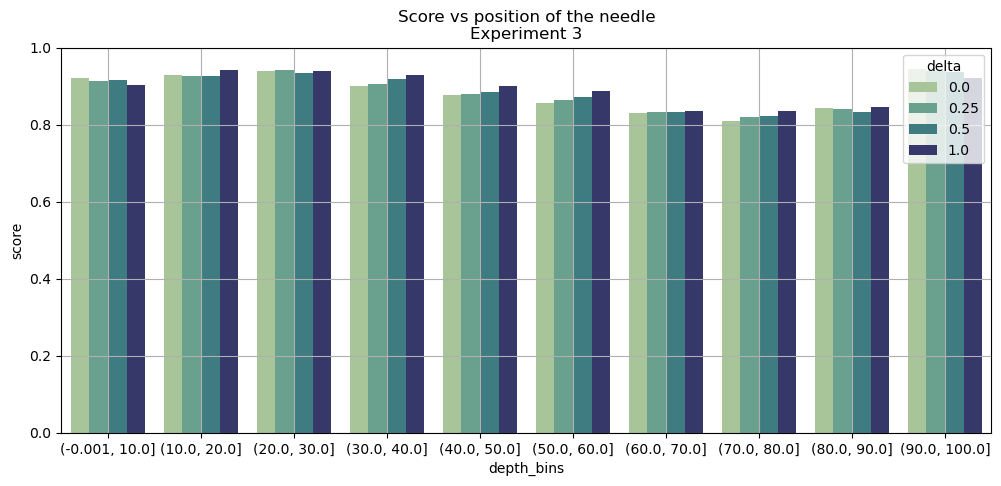

In [15]:
performance_df = results_df\
    .groupby(['delta', "depth_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.figure(figsize=(12,5))

sns.barplot(
    performance_df,
    x = 'depth_bins',
    y = "score",
    hue = "delta",
    palette = "crest"
)

plt.title("Score vs position of the needle\nExperiment 3")
plt.grid()
plt.ylim([0,1])

In [16]:
performance_df = results_df\
    .groupby(['delta', "context_length_bins", "depth_bins"])\
    .score\
    .mean()\
    .reset_index()

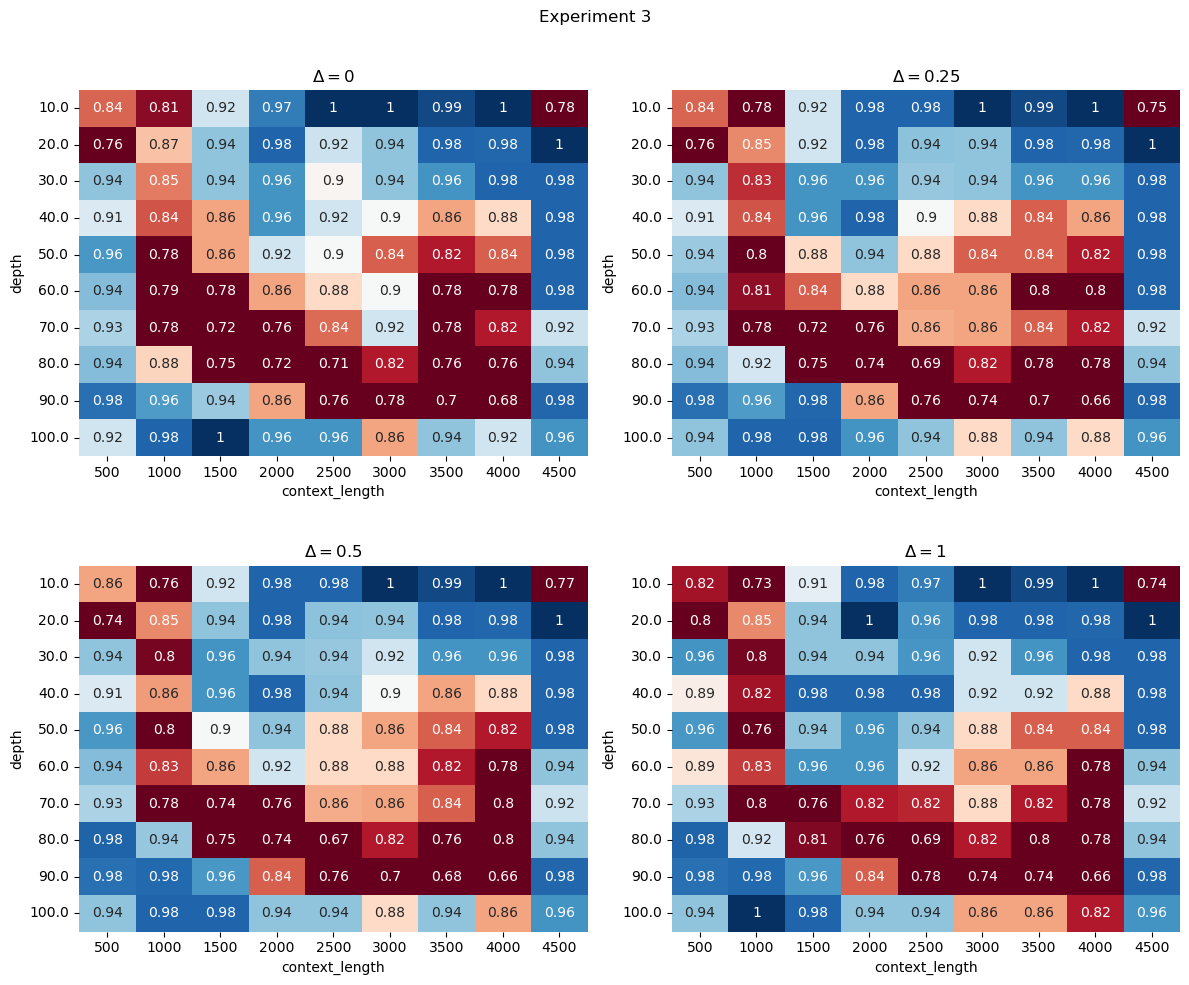

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# List of delta values for each subplot
delta_values = [0, 0.25,0.5, 1]

# Loop over the subplots and delta values
for ax, delta in zip(axes.flat, delta_values):
    heatmap_data = performance_df.query(
        f"delta == {delta}")

    heatmap_data['depth_bins'] = heatmap_data['depth_bins']\
    .apply(lambda x : x.right)

    heatmap_data['context_length_bins'] = heatmap_data['context_length_bins']\
        .apply(lambda x : x.right)

    heatmap_data = heatmap_data\
        .pivot(index="depth_bins", columns="context_length_bins", values="score")
    
    sns.heatmap(heatmap_data, ax=ax, cmap="RdBu", annot=True, cbar=False, vmin = 0.8, vmax = 1)
    ax.set_xlabel("context_length")
    ax.set_ylabel("depth")
    ax.set_title(rf"$\Delta = {delta}$")

# Adjust layout
plt.tight_layout()

plt.suptitle("Experiment 3")
plt.subplots_adjust(top = 0.9)
plt.subplots_adjust(hspace=0.3)

# Show the plot
plt.show()